# Load repo

In [1]:
import os
!git clone https://github.com/intory89/RCVC
os.chdir('RCVC')
os.getcwd()

Cloning into 'RCVC'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 156 (delta 5), reused 87 (delta 4), pack-reused 61
Receiving objects: 100% (156/156), 24.34 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (9/9), done.


'/content/RCVC'

In [2]:
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
!pip3 install -q fairseq

     |████████████████████████████████| 1.7 MB 10.2 MB/s 
     |████████████████████████████████| 145 kB 35.4 MB/s 
     |████████████████████████████████| 90 kB 6.1 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 112 kB 37.5 MB/s 
     |████████████████████████████████| 596 kB 33.5 MB/s 


# Load checkpoint

In [3]:
!pip install gdown
import shutil
os.makedirs('vocoder/checkpoint/VCTK_22K_V1')
!gdown --id 10NhLWRNgXYB4X8OsrMfI0qQ-cTHm2QdD --output g_00500000
!gdown --id 1kbRB3mlnYPOP2g__XtzS_ucCZf2w6GRF --output config.json
shutil.move('g_00500000', 'vocoder/checkpoint/VCTK_22K_V1/') 
shutil.move('config.json', 'vocoder/checkpoint/VCTK_22K_V1/')

Downloading...
From: https://drive.google.com/uc?id=10NhLWRNgXYB4X8OsrMfI0qQ-cTHm2QdD
To: /content/RCVC/g_00500000
100% 55.8M/55.8M [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kbRB3mlnYPOP2g__XtzS_ucCZf2w6GRF
To: /content/RCVC/config.json
100% 758/758 [00:00<00:00, 1.89MB/s]


'vocoder/checkpoint/VCTK_22K_V1/config.json'

In [4]:
os.makedirs('outputs/RCVC_VCTK')
!gdown --id 1w4eLP3xlarH8-p4TVa_XVfosvkc3uN5V --output checkpoint_VCTK_150000
shutil.move('checkpoint_VCTK_150000', 'outputs/RCVC_VCTK/')

Downloading...
From: https://drive.google.com/uc?id=1w4eLP3xlarH8-p4TVa_XVfosvkc3uN5V
To: /content/RCVC/checkpoint_VCTK_150000
100% 3.26G/3.26G [00:45<00:00, 72.1MB/s]


'outputs/RCVC_VCTK/checkpoint_VCTK_150000'

# Load audio

In [5]:
source_path = os.path.join('data/VCTK/original/wav48/p343/p343_010.wav')
Audio(source_path)

In [6]:
target_path = os.path.join('data/VCTK/original/wav48/p311/p311_010.wav')
Audio(target_path)

# Preprocessing

In [7]:
source_audio, _ = librosa.load(source_path, sr=22050)
target_audio, _ = librosa.load(target_path, sr=22050)

In [8]:
# preprocessing parameters
import model.hparams as hp
MAX_WAV_VALUE       = hp.MAX_WAV_VALUE
sampling_rate       = hp.sampling_rate
n_fft               = hp.n_fft
n_mels              = hp.n_mels
hop_size            = hp.hop_size 
win_size            = hp.win_size 
fmin                = hp.fmin         
fmax                = hp.fmax
eps                 = hp.eps
clip_val            = hp.clip_val

In [9]:
from preprocessing import call_generate_melspec
mel_A, processed_audio = call_generate_melspec(
    source_audio, sampling_rate, MAX_WAV_VALUE, n_fft, n_mels, 
    hop_size, win_size, fmin, fmax, eps, clip_val) # [T, 80], [trimed wav length]

mel_B, processed_audio = call_generate_melspec(
    target_audio, sampling_rate, MAX_WAV_VALUE, n_fft, n_mels, 
    hop_size, win_size, fmin, fmax, eps, clip_val) # [T, 80], [trimed wav length]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  normalized, onesided, return_complex)


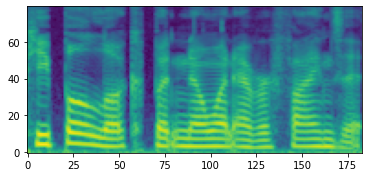

In [10]:
plt.imshow(mel_A.T)
plt.gca().invert_yaxis()

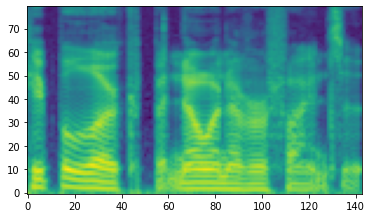

In [11]:
plt.imshow(mel_B.T)
plt.gca().invert_yaxis()

# Load Model

In [12]:
from model.model import Model
import model.hparams as hp
from utils.inference_utils import make_test_pairs, make_experiment_conversion_pair, pad_sequences, read_rhythm, load_data
from vocoder.inference_npy import main as run_vocoder
import torch

In [13]:
rhythm = read_rhythm(os.path.join('data', hp.dataset, hp.dataset_path, 'rhythm.txt')) 

In [14]:
model = Model(hp).cuda(0)
model.load_state_dict(torch.load('outputs/RCVC_VCTK/checkpoint_VCTK_150000')['model'])
model.eval()
print("load model!")

No module named 'lightconv_cuda'
No module named 'lightconv_cuda'
No module named 'lightconv_cuda'
No module named 'lightconv_cuda'
No module named 'lightconv_cuda'
No module named 'lightconv_cuda'
No module named 'lightconv_cuda'
No module named 'lightconv_cuda'
load model!


# Inference

In [15]:
mel_A = mel_A.unsqueeze(0).cuda(0) # [1, T, 80]
mel_B = mel_B.unsqueeze(0).cuda(0)

mel_len_A = torch.LongTensor([mel_A.size(1)]).cuda(0)
mel_len_B = torch.LongTensor([mel_B.size(1)]).cuda(0)

spk_name_A = 'p343'
spk_name_B = 'p311'
rhythm_A = float(rhythm[spk_name_A])    
rhythm_B = float(rhythm[spk_name_B])    

In [16]:
mel_outputs = model.inference(mel_A, mel_len_A, rhythm_A, mel_B, mel_len_B, rhythm_B) 
print(mel_outputs.size())

/content/RCVC/model/loss.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ids = lengths.new_tensor(torch.arange(0, max_len)).to(lengths.get_device())


torch.Size([1, 146, 80])


In [17]:
# save result
source_mel = mel_A.squeeze(0).float().detach().cpu().numpy().T # [1, T, 80] -> [80, T]
target_mel = mel_B.squeeze(0).float().detach().cpu().numpy().T               
converted_mel = mel_outputs.squeeze(0).float().detach().cpu().numpy().T
path = "p343_to_p311.npy"

# Inference result
os.makedirs('generated/RCVC_VCTK', exist_ok=True)
np.save(os.path.join('generated/RCVC_VCTK', path), converted_mel)

# Vocoder

In [18]:
run_vocoder(hp, path=os.path.join('../generated/RCVC_VCTK'))

Initializing Inference Process..
[*] Load checkpoint path: vocoder/checkpoint/VCTK_22K_V1/g_00500000
Loading 'vocoder/checkpoint/VCTK_22K_V1/g_00500000'
Complete.
Removing weight norm...
generated/../generated/RCVC_VCTK/p343_to_p311.wav


# Inference result
## Source speech(Slow speaking speaker)

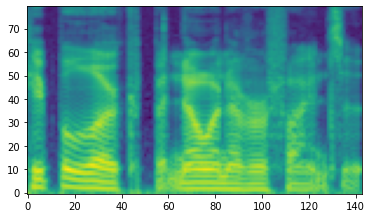

In [19]:
target_path = os.path.join('data/VCTK/original/wav48/p343/p343_010.wav')
plt.imshow(mel_B.squeeze(0).cpu().T)
plt.gca().invert_yaxis()
Audio(target_path)

## Target speech(Fast speaking speaker)

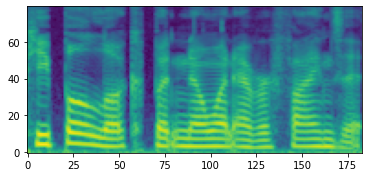

In [20]:
source_path = os.path.join('data/VCTK/original/wav48/p311/p311_010.wav')
plt.imshow(mel_A.squeeze(0).cpu().T)
plt.gca().invert_yaxis()
Audio(source_path)

## Generated speech

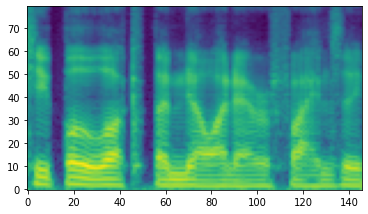

In [21]:
generated_path = os.path.join('generated/RCVC_VCTK/p343_to_p311.wav')
generated_audio, _ = librosa.load(generated_path, sr=22050)
mel_A2B, processed_audio = call_generate_melspec(
    generated_audio, sampling_rate, MAX_WAV_VALUE, n_fft, n_mels, 
    hop_size, win_size, fmin, fmax, eps, clip_val) # [T, 80], [trimed wav length]
plt.imshow(mel_A2B.T)
plt.gca().invert_yaxis()
Audio(generated_path)

# Thank you for your attention!